In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing import image
from matplotlib import pyplot as plt

In [2]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/BigData/fer2013.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


In [4]:
X_train, train_y, X_test, test_y, X_check, check_y=[],[],[],[],[],[]
for index, row in data.iterrows():
  val=row['pixels'].split(" ")
  if 'Training' in row['Usage']:
    X_train.append(np.array(val,'float32'))
    train_y.append(row['emotion'])
  elif 'PublicTest' in row['Usage']:
    X_test.append(np.array(val,'float32'))
    test_y.append(row['emotion'])
  elif 'PrivateTest' in row['Usage']:
    X_check.append(np.array(val,'float32'))
    check_y.append(row['emotion'])

In [5]:
num_labels = 7
batch_size = 64
epochs = 60
width, height = 48, 48

In [6]:
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')
X_check = np.array(X_check,'float32')
check_y = np.array(check_y,'float32')

In [7]:
print(X_train[0])

[ 70.  80.  82. ... 106. 109.  82.]


In [8]:
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)
check_y=np_utils.to_categorical(check_y, num_classes=num_labels)

In [9]:
print(train_y[0])

[1. 0. 0. 0. 0. 0. 0.]


In [10]:
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_check -= np.mean(X_check, axis=0)
X_check /= np.std(X_check, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

X_check = X_check.reshape(X_check.shape[0], 48, 48, 1)

In [11]:
print(X_train[0])

[[[-0.6098866 ]
  [-0.4592209 ]
  [-0.40325198]
  ...
  [-0.7694696 ]
  [-0.90518403]
  [-0.95160526]]

 [[-0.66049284]
  [-0.68162924]
  [-0.694159  ]
  ...
  [-0.7112763 ]
  [-0.7862608 ]
  [-0.90819967]]

 [[-0.83170736]
  [-0.8952668 ]
  [-0.73603356]
  ...
  [-0.7924775 ]
  [-0.7261497 ]
  [-0.8613453 ]]

 ...

 [[-0.33269772]
  [-0.6514918 ]
  [-0.93670547]
  ...
  [-0.5265123 ]
  [-0.7377333 ]
  [-0.9078971 ]]

 [[-0.5099617 ]
  [-0.43692893]
  [-0.46537215]
  ...
  [-0.10019822]
  [-0.5580577 ]
  [-0.86989194]]

 [[-0.5095401 ]
  [-0.56317693]
  [-0.3986179 ]
  ...
  [-0.08629682]
  [-0.0573744 ]
  [-0.41127437]]]


In [12]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

In [13]:
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opt, 
              metrics = ['accuracy'])

In [14]:
history = model.fit(X_train, train_y,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, test_y),
                    shuffle = True)

Epoch 1/60
449/449 [==============================] - 13s 22ms/step - loss: 1.8339 - accuracy: 0.2535 - val_loss: 2.1947 - val_accuracy: 0.2566
Epoch 2/60
449/449 [==============================] - 9s 20ms/step - loss: 1.7013 - accuracy: 0.3167 - val_loss: 1.7759 - val_accuracy: 0.3263
Epoch 3/60
449/449 [==============================] - 9s 20ms/step - loss: 1.6143 - accuracy: 0.3635 - val_loss: 1.6465 - val_accuracy: 0.3709
Epoch 4/60
449/449 [==============================] - 9s 21ms/step - loss: 1.5340 - accuracy: 0.4037 - val_loss: 1.5502 - val_accuracy: 0.4232
Epoch 5/60
449/449 [==============================] - 9s 21ms/step - loss: 1.4808 - accuracy: 0.4251 - val_loss: 1.4898 - val_accuracy: 0.4335
Epoch 6/60
449/449 [==============================] - 9s 20ms/step - loss: 1.4289 - accuracy: 0.4484 - val_loss: 1.4205 - val_accuracy: 0.4670
Epoch 7/60
449/449 [==============================] - 9s 20ms/step - loss: 1.3860 - accuracy: 0.4648 - val_loss: 1.3933 - val_accuracy: 0.478

In [15]:
module_json = model.to_json()
with open("module.json", "w") as json_file:
  json_file.write(module_json)
model.save_weights("module.h5")

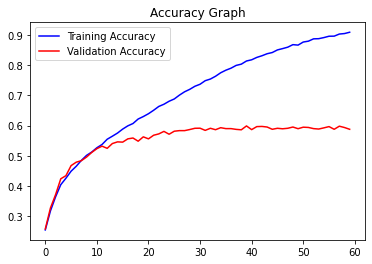

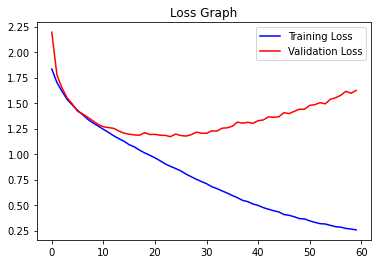

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [17]:
y = model.predict(X_check)

y_pred = np.array([np.argmax(i) for i in y])

y_check_class = np.array([np.argmax(i) for i in check_y])
print("Accuracy: ",sum(y_pred==y_check_class)/len(y_pred))

Accuracy:  0.6029534689328504


In [18]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Predict:  Sad


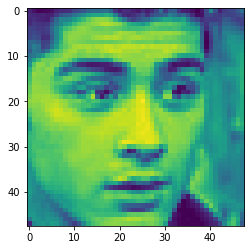

In [19]:
img = image.load_img("PrivateTest_2134320.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
img_index = result.index(max(result))
print("Predict: ", emotion_map[img_index])

Predict:  Happy


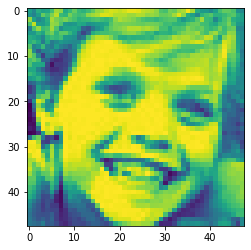

In [22]:
img = image.load_img("PrivateTest_3447769.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])

Predict:  Happy


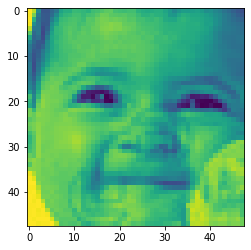

In [24]:
img = image.load_img("PrivateTest_3783569.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])

Predict:  Surprise


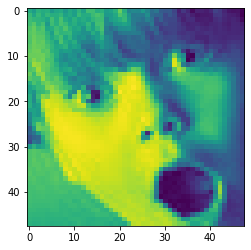

In [29]:
img = image.load_img("PrivateTest_14592510.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)


img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])


Predict:  Angry


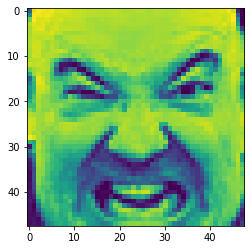

In [30]:
img = image.load_img("PublicTest_99509833.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)


img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])

Predict:  Sad


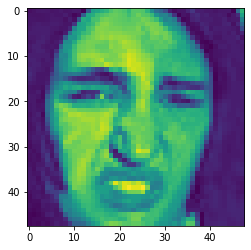

In [32]:
img = image.load_img("PrivateTest_52177909.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])

Predict:  Sad


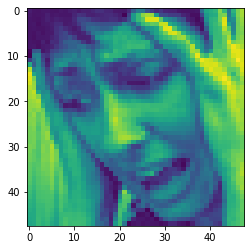

In [33]:
img = image.load_img("PrivateTest_4002000.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])

Predict:  Sad


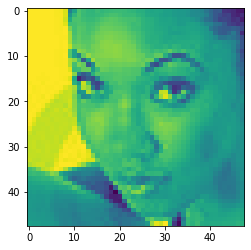

In [35]:
img = image.load_img("PrivateTest_4658147.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img,axis = 0)

img = img.reshape(1,48,48,1)
result = model.predict(img)
result_label = result.argmax()
print("Predict: ", emotion_map[result_label])